# Using XGboost for Variable Importance
In this notebook, the `xgboost` library will be used to determine the importance of the many technical indicators we collected in order to conduct feature reduction.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import math

We first read in our data

In [2]:
df = pd.read_csv("data/fulldata.csv", index_col=0)
df.head()

,Date,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,...,ema,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc,vader_polarity
0,2013-05-09,16.421786,16.535714,16.270714,16.313214,398749904,21.792098,22.012812,21.726785,21.808114,...,16.373799,0.329583,15.313214,66.171526,64.804242,1.021099,0.295000,0.419158,0.165081,0.131248
1,2013-05-10,16.356071,16.418214,16.088572,16.177500,334849928,21.903956,22.034833,21.825130,22.027075,...,16.242933,0.325128,15.177500,57.572386,61.822287,0.931256,0.329643,0.412934,0.159885,0.146785
2,2013-05-13,16.125357,16.353572,16.125000,16.240714,317109240,21.993543,22.083127,21.855684,21.959510,...,16.241454,0.322504,15.240714,60.556778,62.679325,0.966136,0.228572,0.404487,0.140643,0.063889
3,2013-05-14,16.208928,16.257143,15.791071,15.852143,447115760,21.958759,22.238780,21.949751,22.198992,...,15.981913,0.288120,14.852143,39.310535,54.606048,0.719893,0.466071,0.379742,0.092901,0.049072
4,2013-05-15,15.684286,15.750000,15.084286,15.316071,741612360,22.409198,22.931701,22.372159,22.919439,...,15.538019,0.218220,14.316071,24.492002,45.872465,0.533915,0.767857,0.412962,0.057682,0.011088


We separate our predictor variables from the response variable and drop any categorical variables.

In [3]:
x = df.drop(['Date', 'close_aapl'], axis=1)
x

,open_aapl,high_aapl,low_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,volume_googl,open_meta,...,ema,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc,vader_polarity
0,16.421786,16.535714,16.270714,398749904,21.792098,22.012812,21.726785,21.808114,87945080,27.0800,...,16.373799,0.329583,15.313214,66.171526,64.804242,1.021099,0.295000,0.419158,0.165081,0.131248
1,16.356071,16.418214,16.088572,334849928,21.903956,22.034833,21.825130,22.027075,75955060,27.1400,...,16.242933,0.325128,15.177500,57.572386,61.822287,0.931256,0.329643,0.412934,0.159885,0.146785
2,16.125357,16.353572,16.125000,317109240,21.993543,22.083127,21.855684,21.959510,57893080,26.6000,...,16.241454,0.322504,15.240714,60.556778,62.679325,0.966136,0.228572,0.404487,0.140643,0.063889
3,16.208928,16.257143,15.791071,447115760,21.958759,22.238780,21.949751,22.198992,63190600,26.8854,...,15.981913,0.288120,14.852143,39.310535,54.606048,0.719893,0.466071,0.379742,0.092901,0.049072
4,15.684286,15.750000,15.084286,741612360,22.409198,22.931701,22.372159,22.919439,159658020,26.9200,...,15.538019,0.218220,14.316071,24.492002,45.872465,0.533915,0.767857,0.412962,0.057682,0.011088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2487,159.940000,160.770000,157.870000,52390266,104.615000,104.760000,101.927300,102.460000,31120864,204.8100,...,158.756022,2.923728,157.280000,58.221301,60.577495,0.961104,2.900000,3.498250,0.028928,0.154446
2488,157.970000,158.490000,155.980000,45992152,102.440000,102.450000,99.740000,101.030000,32057865,200.1500,...,158.018674,2.811818,156.650000,53.185052,59.113390,0.899712,2.510000,3.543964,0.039908,0.171291
2489,159.370000,161.050000,159.350000,51305691,102.280000,102.490000,100.650000,101.390000,28779572,203.5600,...,159.852891,2.940983,159.770000,69.511345,63.760854,1.090188,3.400000,3.478964,0.051678,0.149073
2490,161.530000,162.470000,161.271000,49501689,100.910000,101.155000,99.780000,100.890000,33086183,203.3800,...,161.524297,3.135504,161.360000,75.053359,65.878571,1.139268,1.700000,3.362507,0.078159,0.000000


In [4]:
y = df.close_aapl
y

0        16.313214
1        16.177500
2        16.240714
3        15.852143
4        15.316071
           ...    
2487    158.280000
2488    157.650000
2489    160.770000
2490    162.360000
2491    164.900000
Name: close_aapl, Length: 2492, dtype: float64

The dataset will be split 80/20 for training/testing

In [5]:
training_data_len = math.ceil(len(df) * 0.8)
training_data_len

1994

In [6]:
df[0:training_data_len]

,Date,open_aapl,high_aapl,low_aapl,close_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,...,ema,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc,vader_polarity
0,2013-05-09,16.421786,16.535714,16.270714,16.313214,398749904,21.792098,22.012812,21.726785,21.808114,...,16.373799,0.329583,15.313214,66.171526,64.804242,1.021099,0.295000,0.419158,0.165081,0.131248
1,2013-05-10,16.356071,16.418214,16.088572,16.177500,334849928,21.903956,22.034833,21.825130,22.027075,...,16.242933,0.325128,15.177500,57.572386,61.822287,0.931256,0.329643,0.412934,0.159885,0.146785
2,2013-05-13,16.125357,16.353572,16.125000,16.240714,317109240,21.993543,22.083127,21.855684,21.959510,...,16.241454,0.322504,15.240714,60.556778,62.679325,0.966136,0.228572,0.404487,0.140643,0.063889
3,2013-05-14,16.208928,16.257143,15.791071,15.852143,447115760,21.958759,22.238780,21.949751,22.198992,...,15.981913,0.288120,14.852143,39.310535,54.606048,0.719893,0.466071,0.379742,0.092901,0.049072
4,2013-05-15,15.684286,15.750000,15.084286,15.316071,741612360,22.409198,22.931701,22.372159,22.919439,...,15.538019,0.218220,14.316071,24.492002,45.872465,0.533915,0.767857,0.412962,0.057682,0.011088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,2021-04-05,123.870000,126.160100,123.070000,125.900000,88651175,107.357500,111.449500,107.260250,110.948000,...,124.772501,-0.879579,124.900000,74.887677,54.460429,1.375084,3.160100,2.869579,0.040238,0.251110
1990,2021-04-06,126.500000,127.130000,125.650000,126.210000,80171253,110.546000,111.400000,110.089500,110.463000,...,125.730834,-0.513029,125.210000,75.995103,54.998316,1.381771,1.480000,2.744579,0.017905,0.101529
1991,2021-04-07,125.830000,127.920000,125.140000,127.900000,83466716,110.655000,112.225000,110.655000,111.951500,...,127.176945,-0.085185,126.900000,81.541976,57.902640,1.408260,2.780000,2.691443,0.018555,0.199921
1992,2021-04-08,128.950000,130.390000,128.520000,130.360000,88844591,113.200000,113.589495,112.150500,112.521500,...,129.298982,0.447230,129.360000,87.005443,61.752388,1.408941,2.490000,2.552157,0.044886,0.125479


In [7]:
# creating training sets for x and y
x_train = x[:training_data_len]
y_train = y[:training_data_len]

# creating testing sets for x and y
x_test = x[training_data_len:]
y_test = y[training_data_len:]

print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print()
print('x_test shape: ' + str(x_test.shape))
print('y_test shape: ' + str(y_test.shape))

x_train shape: (1994, 49)
y_train shape: (1994,)

x_test shape: (498, 49)
y_test shape: (498,)


In [8]:
x_train

,open_aapl,high_aapl,low_aapl,volume_aapl,open_googl,high_googl,low_googl,close_googl,volume_googl,open_meta,...,ema,macd,momentum,rsi_5,rsi_15,rsi_ratio,tr,atr,roc,vader_polarity
0,16.421786,16.535714,16.270714,398749904,21.792098,22.012812,21.726785,21.808114,87945080,27.0800,...,16.373799,0.329583,15.313214,66.171526,64.804242,1.021099,0.295000,0.419158,0.165081,0.131248
1,16.356071,16.418214,16.088572,334849928,21.903956,22.034833,21.825130,22.027075,75955060,27.1400,...,16.242933,0.325128,15.177500,57.572386,61.822287,0.931256,0.329643,0.412934,0.159885,0.146785
2,16.125357,16.353572,16.125000,317109240,21.993543,22.083127,21.855684,21.959510,57893080,26.6000,...,16.241454,0.322504,15.240714,60.556778,62.679325,0.966136,0.228572,0.404487,0.140643,0.063889
3,16.208928,16.257143,15.791071,447115760,21.958759,22.238780,21.949751,22.198992,63190600,26.8854,...,15.981913,0.288120,14.852143,39.310535,54.606048,0.719893,0.466071,0.379742,0.092901,0.049072
4,15.684286,15.750000,15.084286,741612360,22.409198,22.931701,22.372159,22.919439,159658020,26.9200,...,15.538019,0.218220,14.316071,24.492002,45.872465,0.533915,0.767857,0.412962,0.057682,0.011088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1989,123.870000,126.160100,123.070000,88651175,107.357500,111.449500,107.260250,110.948000,48509600,300.8900,...,124.772501,-0.879579,124.900000,74.887677,54.460429,1.375084,3.160100,2.869579,0.040238,0.251110
1990,126.500000,127.130000,125.650000,80171253,110.546000,111.400000,110.089500,110.463000,35240780,308.8365,...,125.730834,-0.513029,125.210000,75.995103,54.998316,1.381771,1.480000,2.744579,0.017905,0.101529
1991,125.830000,127.920000,125.140000,83466716,110.655000,112.225000,110.655000,111.951500,24133920,306.3400,...,127.176945,-0.085185,126.900000,81.541976,57.902640,1.408260,2.780000,2.691443,0.018555,0.199921
1992,128.950000,130.390000,128.520000,88844591,113.200000,113.589495,112.150500,112.521500,28664280,314.8500,...,129.298982,0.447230,129.360000,87.005443,61.752388,1.408941,2.490000,2.552157,0.044886,0.125479


Then we fit the model

In [17]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
model = xgb.XGBRegressor(seed = 15)

clf = GridSearchCV(estimator=model, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

clf.fit(x_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
   

In [18]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 1000}
Lowest RMSE:  20.28527080322342


We'll calculate the RMSE for both the training and testing datasets to evaluate how well the model fits the data.

0.0011167509565246888

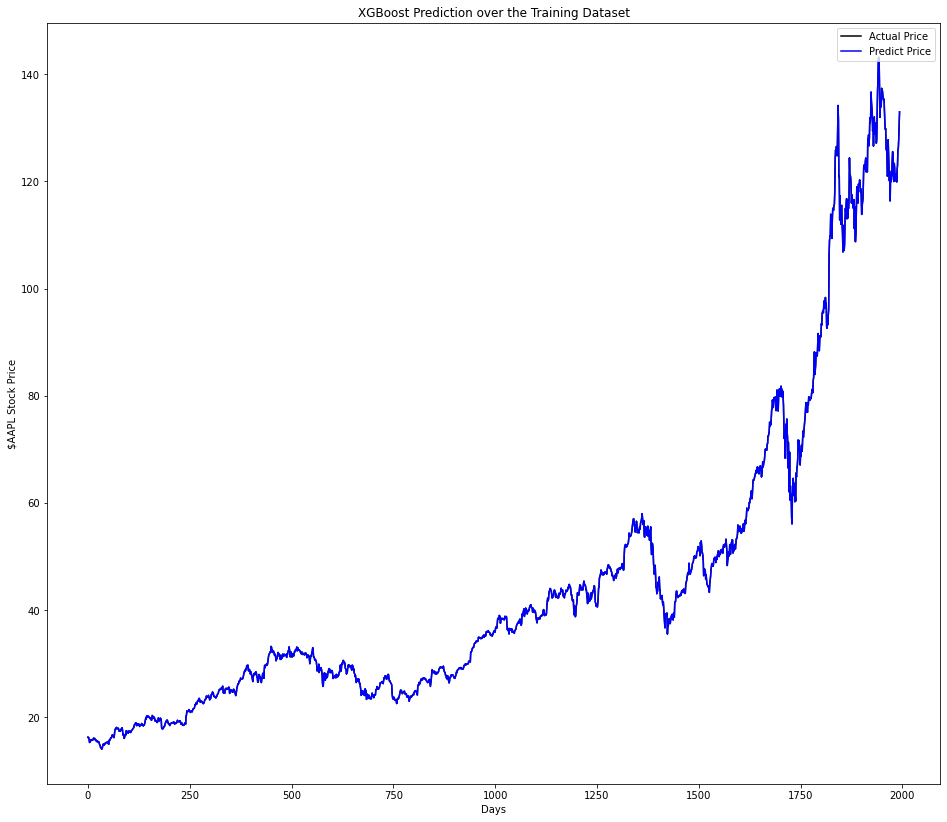

In [21]:
y_hat_train = clf.predict(x_train)

plt.figure(figsize=(16, 14))
plt.plot(y_train, color = 'black', label = 'Actual Price')
plt.plot(y_hat_train, color = 'blue', label = 'Predict Price')
plt.title('XGBoost Prediction over the Training Dataset')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_hat_train, y_train)
RMSE = math.sqrt(MSE)
RMSE

14.646853225416903

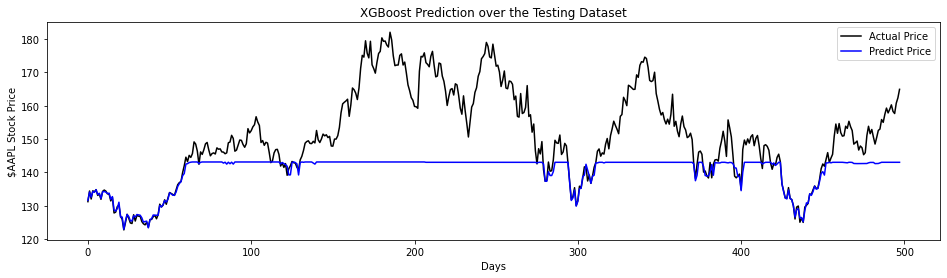

In [23]:
y_hat_test = clf.predict(x_test)

plt.figure(figsize=(16, 4))
plt.plot(y_test.values, color = 'black', label = 'Actual Price')
plt.plot(y_hat_test, color = 'blue', label = 'Predict Price')
plt.title('XGBoost Prediction over the Testing Dataset')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_hat_test, y_test)
RMSE = math.sqrt(MSE)
RMSE

We can then plot the generated variable importance plot.

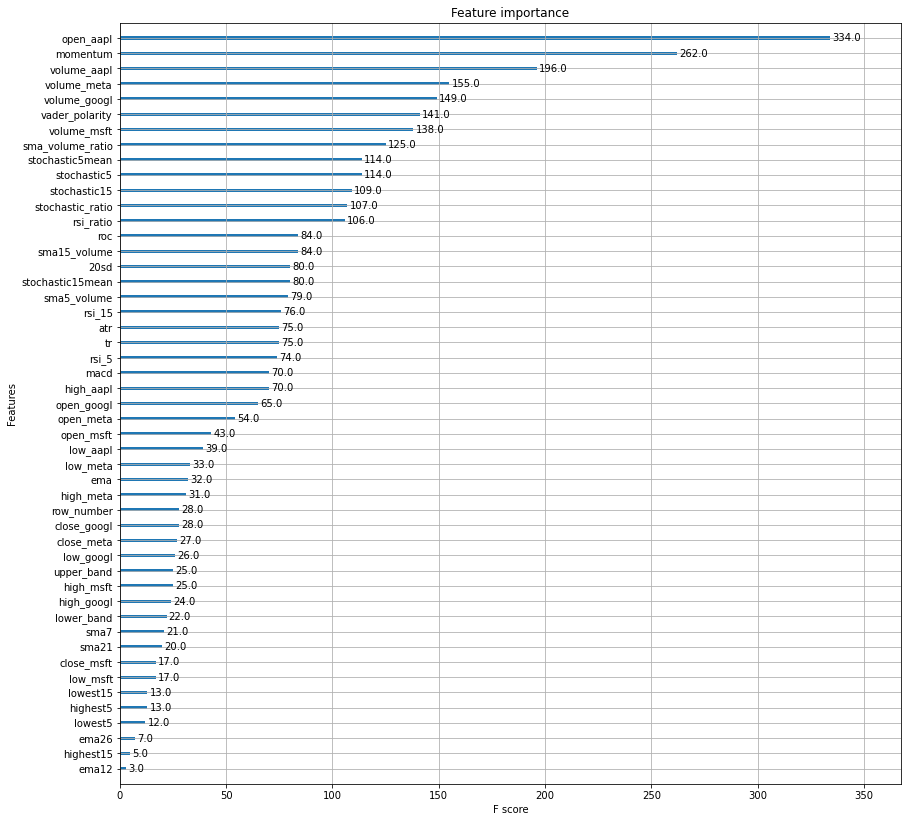

In [14]:
plt.rcParams["figure.figsize"] = (14, 14)
xgb.plot_importance(model)
plt.savefig("importance.png", dpi=200)